### Import

In [1]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image as image_utils
from collections import namedtuple

2023-10-02 11:27:39.092458: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 11:27:39.382913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 11:27:40.159732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Identification des catégories

In [2]:
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [3]:
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [4]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [5]:
labels_mapping = dict([(x.category, x.categoryId) for x in labels])

## Méthodes du projet

### Exploration des données

In [6]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    """ Affiche le pourcentage de chaque portion si la condition est vérifiée """
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [7]:
def show_unique_values(df, col, display_pie=True, silent=False, cumul_threshold=85):
    """
    Affiche la liste des valeurs uniques contenues dans une colonne
    Affiche le pie chart de ces données également
    """
    temp_val_count = df[col].value_counts(normalize=True)
    df_val_count = temp_val_count.rename_axis("label").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= cumul_threshold, :]
    
    if silent:
        return sub_display
    
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()
    return sub_display

In [25]:
def explore_data_folders(path):
    temp_dict = {
        'set_type': [],
        'city': [],
        'n_pictures': [],
        'n_json_data': []
    }
    
    # explore the folders data
    for root, dirs, files in os.walk(path):
        
        # get the useful informations
        if len(files) > 2:
            dict_type_files = {
                'png': 0,
                'json': 0
            }
            for elt in files:
                if elt.endswith("json"):
                    dict_type_files['json'] += 1
                elif elt.endswith("png"):
                    dict_type_files['png'] += 1
            
            spli_root = root.split("/")
            temp_dict['set_type'].append(spli_root[-2])
            temp_dict['city'].append(spli_root[-1])
            temp_dict['n_pictures'].append(dict_type_files['png'])
            temp_dict['n_json_data'].append(dict_type_files['json'])
    
    # convert dict to df to use it and sort it by dataset type
    res_df = pd.DataFrame(temp_dict)
    res_df["customOrder"] = res_df['set_type'].apply(lambda x: ['train', 'val', 'test'].index(x))
    res_df = res_df.sort_values(by='customOrder')
    res_df = res_df.drop(columns=['customOrder'])
    
    # display informations about the data    
    nb_cities_by_dataset = res_df.groupby('city', sort=False).agg({'n_pictures': 'sum'})
    for index, row in nb_cities_by_dataset.iterrows():
        print("Pour la ville de'", index, "', nous avons", row['n_pictures'], "images.")
    
    nb_cities_by_dataset = res_df.groupby('set_type', sort=False).agg({'city': 'count'})
    for index, row in nb_cities_by_dataset.iterrows():
        print("Dans le dataset de type'", index, "', nous avons", row['city'], "villes.")
    print("Pour un total de", nb_cities_by_dataset['city'].sum(), "villes.")
          
    nb_pics_by_dataset = res_df.groupby('set_type', sort=False).agg({'n_pictures': 'sum'})
    for index, row in nb_pics_by_dataset.iterrows():
        print("Dans le dataset de type'", index, "', nous avons", row['n_pictures'], "images.")
    print("Pour un total de", nb_pics_by_dataset['n_pictures'].sum(), "images.")
          
    nb_json_by_dataset = res_df.groupby('set_type', sort=False).agg({'n_json_data': 'sum'})
    if nb_json_by_dataset['n_json_data'].sum() > 0:
        for index, row in nb_json_by_dataset.iterrows():
            print("Dans le dataset de type'", index, "', nous avons", row['n_json_data'], "fichiers json.")
        print("Pour un total de", nb_json_by_dataset['n_json_data'].sum(), "fichiers data en json.")
    
    return res_df

### Chargement des données

In [26]:
def load_data_from_json_files(begin_path, correspondig_dict_categ={}, labels_mapping={}, nb_files=10):
    start = time.time()
    res_df = pd.DataFrame()
    count_files = 0
    for root, dirs, files in os.walk(begin_path):
        if len(files) > 2:
            for elt in files:
                if elt.endswith("json"):
                    print(elt)
                    count_files += 1
                    # load data
                    temp_path = root + "/" + elt
                    temp_df = pd.read_json(temp_path)

                    # convert dictionary objects into 2 columns
                    temp_df = pd.concat([temp_df.drop(['objects'], axis=1), temp_df['objects'].apply(pd.Series)], axis=1)

                    # add few data into new columns
                    split_name = elt.split("_")
                    split_root = root.split("/")
                    temp_df["city"] = split_name[0]
                    temp_df["pic_id"] = "_".join(split_name[1:3])
                    temp_df["set_type"] = split_root[-2]
                    
                    # concatenante the data continuously
                    res_df = pd.concat([res_df, temp_df])
                    
                    if count_files == nb_files:
                        break
                        
        if count_files == nb_files:
            break
                    
    # add main category aka main target with the correspondance
    if correspondig_dict_categ:
        flatten_dict = {val:key for key, lst in correspondig_dict_categ.items() for val in lst}
        res_df["target"] = res_df["label"].map(flatten_dict)
    
    # add correspondance label and its id
    if labels_mapping:
        res_df["target_id"] = res_df["target"].map(labels_mapping)
    
    # delete dimension column because exactly the same for all, 1024 x 2048
    res_df.drop(columns=['imgHeight', 'imgWidth'], inplace=True)
    
    end = time.time()
    delta = round(end - start, 0)
    print("Execution time of load_data_from_json_files() is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
    return res_df

In [27]:
def load_data_from_labelid_files(begin_path, correspondig_dict_categ={}, labels_mapping={}, nb_files=10):
    start = time.time()
    res_df = pd.DataFrame()
    temp_res_dict = {
        'city': [],
        'pic_id': [],
        'label_id': [],
        'target': [],
        'nb_pixels': []
    }
    count_files = 0
    for root, dirs, files in os.walk(begin_path):
        if len(files) > 2:
            for elt in files:
                if elt.endswith("labelIds.png"):
                    count_files += 1
                    # load picture
                    temp_path = root + "/" + elt
                    img = image_utils.img_to_array(image_utils.load_img(temp_path))
                    invent_ids = np.unique(img, return_counts=True)
                    # temp_pic_id = "_".join(elt.split("_")[1:3])
                    split_name = elt.split("_")
                    for categ, nb_pix in zip(invent_ids[0], invent_ids[1]):
                        temp_res_dict["city"].append(split_name[0])
                        temp_res_dict["pic_id"].append("_".join(split_name[1:3]))
                        # temp_res_dict["pic_id"].append(temp_pic_id)
                        temp_res_dict["label_id"].append(categ)
                        temp_key = [k for k, v in cats.items() if categ in v]
                        temp_res_dict["target"].append(temp_key[0])
                        temp_res_dict["nb_pixels"].append(nb_pix)
                        
                    
                    if count_files == nb_files:
                        break
                        
        if count_files == nb_files:
            break
            
    res_df = pd.DataFrame(temp_res_dict)
    res_df['label_id'] = res_df['label_id'].astype('Int64')
    
    # add correspondance label and its id
    if labels_mapping:
        res_df["target_id"] = res_df["target"].map(labels_mapping)
        
    end = time.time()
    delta = round(end - start, 0)
    print("Execution time of load_data_from_labelid_files() is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
    return res_df

# Explorations des données

## Images brutes

Dans les données fournies, nous avons des images brutes. Il s'agit des images issues de la partie "Acquisition des images en temps réel" du projet.  
Elles sont scindées en 3 parties correspondant aux 3 jeux de données nécessaires à une étude de machine learning : 
 - le jeu d'entraînement
 - le jeu de validation
 - le jeu de test

In [28]:
df_raw_pictures = explore_data_folders("P8_Cityscapes_leftImg8bit_trainvaltest/")

Pour la ville de' hanover ', nous avons 196 images.
Pour la ville de' hamburg ', nous avons 248 images.
Pour la ville de' monchengladbach ', nous avons 94 images.
Pour la ville de' krefeld ', nous avons 99 images.
Pour la ville de' ulm ', nous avons 95 images.
Pour la ville de' bochum ', nous avons 96 images.
Pour la ville de' zurich ', nous avons 122 images.
Pour la ville de' strasbourg ', nous avons 365 images.
Pour la ville de' darmstadt ', nous avons 85 images.
Pour la ville de' jena ', nous avons 119 images.
Pour la ville de' erfurt ', nous avons 109 images.
Pour la ville de' cologne ', nous avons 154 images.
Pour la ville de' tubingen ', nous avons 144 images.
Pour la ville de' weimar ', nous avons 142 images.
Pour la ville de' stuttgart ', nous avons 196 images.
Pour la ville de' aachen ', nous avons 174 images.
Pour la ville de' bremen ', nous avons 316 images.
Pour la ville de' dusseldorf ', nous avons 221 images.
Pour la ville de' frankfurt ', nous avons 267 images.
Pour la v

## Données annotées

In [29]:
df_annot_pictures = explore_data_folders("P8_Cityscapes_gtFine_trainvaltest/")

Pour la ville de' hanover ', nous avons 588 images.
Pour la ville de' hamburg ', nous avons 744 images.
Pour la ville de' monchengladbach ', nous avons 282 images.
Pour la ville de' krefeld ', nous avons 297 images.
Pour la ville de' ulm ', nous avons 285 images.
Pour la ville de' bochum ', nous avons 288 images.
Pour la ville de' zurich ', nous avons 366 images.
Pour la ville de' strasbourg ', nous avons 1095 images.
Pour la ville de' darmstadt ', nous avons 255 images.
Pour la ville de' jena ', nous avons 357 images.
Pour la ville de' erfurt ', nous avons 327 images.
Pour la ville de' cologne ', nous avons 462 images.
Pour la ville de' tubingen ', nous avons 432 images.
Pour la ville de' weimar ', nous avons 426 images.
Pour la ville de' stuttgart ', nous avons 588 images.
Pour la ville de' aachen ', nous avons 522 images.
Pour la ville de' bremen ', nous avons 948 images.
Pour la ville de' dusseldorf ', nous avons 663 images.
Pour la ville de' frankfurt ', nous avons 801 images.
Pou

Entre les images brutes et les données de segmentation, nous avons bien le même nombre de villes par type de dataset et le même nombre au total.

En revanche, concernant le nombre de fichiers, il y a une différence. En effet, les données sont réparties en 4 types de données : 
 - une image avec la segmentation sous forme de polygone coloré
 - une image dont la couleur de l'objet correspond à l'id de l'objet
 - une image dont la couleur de l'objet correspond à l'id de la catégorie
 - un fichier json regroupant les données : chaque polygone de couleur avec ses coordonnées et sa catégorie

A chaque image brute, correspond un lot de 4 fichiers (3 images + 1 json). On a donc bien 5 000 images brutes pour 4 x 5 000 lot de données. Nos données sont cohérentes.

## Données json and labelids

### Chargement

In [30]:
dict_categ_subcateg = {
    'flat': ['road', 'sidewalk', 'parking', 'rail track'],
    'human': ['person', 'rider', 'persongroup', 'ridergroup'],
    'vehicle': ["car", "truck", "bus", "motorcycle", "bicycle", "caravan", "trailer", "bicyclegroup", "motorcyclegroup", "train", "cargroup", "truckgroup", "license plate", "ego vehicle"],
    'construction': ["building", "wall", "fence", "guard rail", "bridge", "tunnel"],
    'object': ["pole", "traffic sign", "traffic light", "polegroup"],
    'nature': ["vegetation", "terrain"],
    'sky': ["sky"],
    'void': ["ground", "dynamic", "static", "rectification border", "out of roi"]
}

En étudiant le jeu de données fourni, on peut distinguer les différentes catégories d'objet détectées.

In [31]:
sub_categ_count = 0
for categ, subcategs in dict_categ_subcateg.items():
    print("Dans la catégorie '", categ, "', il y a", len(subcategs), "sous-catégories.")
    sub_categ_count += len(subcategs)
print("Pour un toal de", sub_categ_count, "sous-catégories.")

Dans la catégorie ' flat ', il y a 4 sous-catégories.
Dans la catégorie ' human ', il y a 4 sous-catégories.
Dans la catégorie ' vehicle ', il y a 14 sous-catégories.
Dans la catégorie ' construction ', il y a 6 sous-catégories.
Dans la catégorie ' object ', il y a 4 sous-catégories.
Dans la catégorie ' nature ', il y a 2 sous-catégories.
Dans la catégorie ' sky ', il y a 1 sous-catégories.
Dans la catégorie ' void ', il y a 5 sous-catégories.
Pour un toal de 40 sous-catégories.


On charge les données issues de 2 sources : 
 - les fichiers data json
 - les images encodées avec les identifiants des labels

In [32]:
json_files_path = "P8_Cityscapes_gtFine_trainvaltest/gtFine/"
if os.path.exists("data_from_json.csv") and os.path.exists("data_from_labelid.csv"):
    data_from_json = pd.read_csv("data_from_json.csv", sep='\t', encoding='utf-8', index_col=0)
    data_from_labelid = pd.read_csv("data_from_labelid.csv", sep='\t', encoding='utf-8', index_col=0)
else:
    data_from_json = load_data_from_json_files(json_files_path, correspondig_dict_categ=dict_categ_subcateg, labels_mapping=labels_mapping)
    data_from_json.to_csv("data_from_json.csv", sep='\t', encoding='utf-8')
    data_from_labelid = load_data_from_labelid_files(json_files_path, correspondig_dict_categ=dict_categ_subcateg, labels_mapping=labels_mapping)
    data_from_labelid.to_csv("data_from_labelid.csv", sep='\t', encoding='utf-8')

### Etude des données

In [33]:
data_from_json.head(10)

,label,polygon,city,pic_id,set_type,target,target_id
0,sky,"[[126, 9], [235, 182], [797, 315], [1045, 339]...",lindau,000057_000019,val,sky,5
1,road,"[[37, 561], [362, 514], [811, 398], [955, 361]...",lindau,000057_000019,val,flat,1
2,building,"[[1140, 324], [1139, 334], [1138, 337], [1123,...",lindau,000057_000019,val,construction,2
3,vegetation,"[[1129, 376], [1127, 371], [1127, 369], [1125,...",lindau,000057_000019,val,nature,4
4,building,"[[1073, 337], [1072, 294], [1055, 291], [1049,...",lindau,000057_000019,val,construction,2
5,vegetation,"[[870, 378], [880, 376], [884, 376], [888, 377...",lindau,000057_000019,val,nature,4
6,cargroup,"[[962, 400], [963, 398], [963, 394], [963, 392...",lindau,000057_000019,val,vehicle,7
7,cargroup,"[[921, 391], [913, 388], [909, 386], [904, 386...",lindau,000057_000019,val,vehicle,7
8,building,"[[861, 260], [838, 262], [819, 261], [812, 261...",lindau,000057_000019,val,construction,2
9,car,"[[860, 397], [843, 396], [838, 397], [839, 401...",lindau,000057_000019,val,vehicle,7


In [34]:
data_from_labelid.head()

,city,pic_id,label_id,target,nb_pixels,target_id
0,lindau,000006_000019,1,void,244602,0
1,lindau,000006_000019,3,void,94902,0
2,lindau,000006_000019,4,void,107100,0
3,lindau,000006_000019,5,void,1584,0
4,lindau,000006_000019,6,void,38214,0


,%,%_cumul
label,,
pole,16.55,16.55
vegetation,15.47,32.02
static,12.23,44.25
building,11.51,55.76
car,11.51,67.27
traffic sign,5.76,73.03
out of roi,3.60,76.63


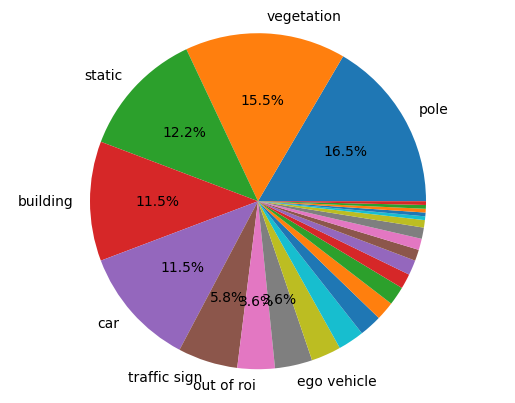

In [35]:
limit_perc = 3
res = show_unique_values(data_from_json, 'label', cumul_threshold=80)

,%,%_cumul
label,,
object,22.30,22.30
void,19.06,41.36
vehicle,18.71,60.07
nature,16.55,76.62
construction,13.67,90.29
flat,4.68,94.97
sky,2.88,97.85
human,2.16,100.01


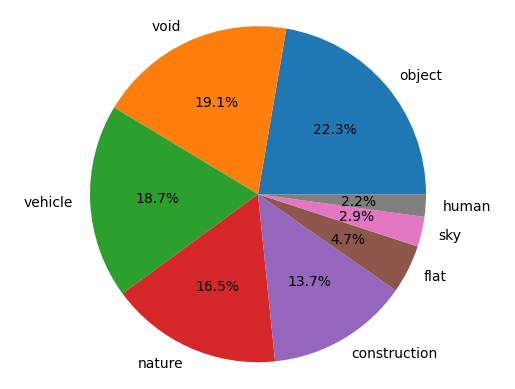

In [36]:
limit_perc = 1
res = show_unique_values(data_from_json, 'target', cumul_threshold=101)

En regardant la répartition de la target sur toutes les données, on peut voir qu'il y a toutes les catégories. Cependant, ce n'est pas homogène. Ce qui n'est pas un problème en soi puisque les catégories 'human' et 'nature', par exemple, doivent effectivement prendre moins de place que 'vehicle'. Cela semble cohérent avec un environnement urbain classique.  
En revanche, il est primordiale que nos données soient cohérentes entre elles. Cela signifie qu'il faut que les proportions de chaque catégorie soient similaires d'un type de dataset à l'autre.

Pour le type de données ' train ' on a les villes suivantes :


,%,%_cumul
label,,


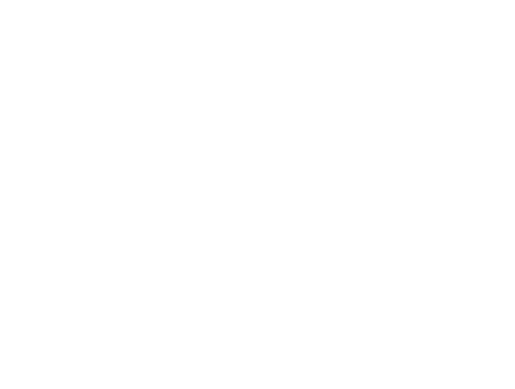

Pour le type de données ' val ' on a les villes suivantes :


,%,%_cumul
label,,
object,22.30,22.30
void,19.06,41.36
vehicle,18.71,60.07
nature,16.55,76.62
construction,13.67,90.29
flat,4.68,94.97
sky,2.88,97.85
human,2.16,100.01


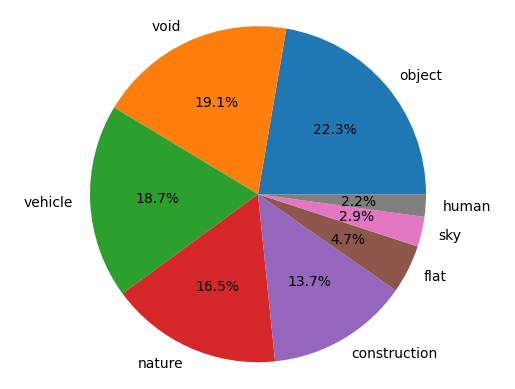

Pour le type de données ' test ' on a les villes suivantes :


,%,%_cumul
label,,


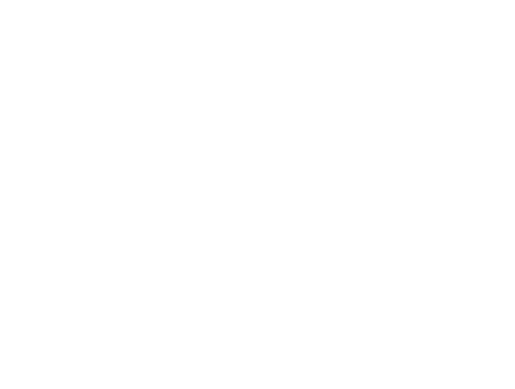

In [37]:
compare_dataset_df = pd.DataFrame.from_dict(labels_mapping, orient='index', columns=['target_id'])
compare_dataset_df.index.names = ['label']
for set_type in ["train", "val", "test"]:
    temp_type_data = data_from_json.loc[data_from_json["set_type"] == set_type, :]
    print("Pour le type de données '", set_type, "' on a les villes suivantes :")
    res = show_unique_values(temp_type_data, "target", cumul_threshold=105)
    compare_dataset_df = pd.merge(compare_dataset_df, res[['%']], how='outer', on='label')
    compare_dataset_df.rename(columns={"%": "%_{}".format(set_type)}, inplace=True)

In [38]:
compare_dataset_df['%_delta_train_val'] = compare_dataset_df[['%_train','%_val']].pct_change(axis=1)['%_val']
compare_dataset_df

,target_id,%_train,%_val,%_test,%_delta_train_val
label,,,,,
void,0,NaN,19.06,NaN,NaN
flat,1,NaN,4.68,NaN,NaN
construction,2,NaN,13.67,NaN,NaN
object,3,NaN,22.30,NaN,NaN
nature,4,NaN,16.55,NaN,NaN
sky,5,NaN,2.88,NaN,NaN
human,6,NaN,2.16,NaN,NaN
vehicle,7,NaN,18.71,NaN,NaN


On peut voir tout de suite que les données du jeu de test ne présentent que 2 catégories. Certes, cela ne nous permettra pas de mesurer les performances sur ce dataset, mais ce n'est pas un frein pour l'utiliser.  
Regardons maintenant les datasets d'entraînement et de validation. On peut voir que la différence de porportion entre les 2 est très faible, autour de 0.2% pour les plus différents. Notre dataset est donc compatible avec une étude de machine learning.

Un autre aspect intéressant est de vérifier si les données sont cohérentes entre les fichiers json et les images avec les masks.

In [39]:
# get only the train and val datasets
temp_data_to_check = data_from_json.loc[data_from_json["set_type"] != "test"]
# list of unique pic_id : couple pic_id/city
unique_data_list = temp_data_to_check[['pic_id', 'city']].drop_duplicates(subset = ['pic_id', 'city'])
# pick up sampel row to check
sample_rows = unique_data_list.sample(n=10, random_state=42)

In [40]:
list_pics_to_check = sample_rows.values.tolist()
nb_tot = len(list_pics_to_check)
count_test = 0
for unique_id in list_pics_to_check:
    temp_data_from_json = data_from_json.loc[(data_from_json["pic_id"] == unique_id[0]) & (data_from_json["city"] == unique_id[1])]
    temp_data_from_labelids = data_from_labelid.loc[(data_from_labelid["pic_id"] == unique_id[0]) & (data_from_labelid["city"] == unique_id[1])]
    categ_from_json = temp_data_from_json["target_id"].unique()
    categ_from_labelid = temp_data_from_labelids["target_id"].unique()
    if categ_from_json.sort() == categ_from_labelid.sort():
        count_test += 1
if count_test == nb_tot:
    print("L'ensemble de l'échantillon est cohérent.")

L'ensemble de l'échantillon est cohérent.


Nous avons pu montrer sur un échantillon que les catégories présentes sur les masks sont cohérentes avec les catégories répertoriées sur les données json.